In [131]:
#for data manipulation
import pandas as pd
import numpy as np
#for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#for importing files-optional
import os
#for displaying images
from IPython.display import Image
#for preprocessing the data
from sklearn.preprocessing import StandardScaler, LabelEncoder
#for cross-validation
from sklearn.cross_validation import StratifiedKFold, train_test_split
#for scoring
from sklearn.metrics import log_loss
#for dimenion reduction
from sklearn.decomposition import PCA
#for benchmarking
from sklearn.neighbors import KNeighborsClassifier
#for neural network model building
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.utils.np_utils import to_categorical
#for gridsearching
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

In [2]:
#identifying the folder to import the files from
file_path = 'C:\\hudsondata\\Machine Learning\\Kaggle\\Leaves'

In [3]:
train = pd.read_csv(os.path.join(file_path,'train.csv'))
test = pd.read_csv(os.path.join(file_path,'test.csv'))

# Data Preprocessing and Validation Split

Label Encoding the Response Variable

In [4]:
#label encoding the species column of the train dataset and assigning to y
lespecies = LabelEncoder()
lespecies.fit(train['species'])
y = lespecies.transform(train['species'])

In [5]:
#removing the species column from the train dataset
species = train.pop('species')

In [6]:
#setting id column as the index of the dataframe
train = train.set_index('id')
test = test.set_index('id')

Split Train, Test Data to 80/20

In [8]:
#splitting train data to 80/20 to use 20% as validation set, with y variable stratified
X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=0.2,random_state=0, stratify=y)

Standardize Data

In [9]:
#fitting the standardization method to the 80% of the data and using this to transform the 80% of the train and the 20% of validation
scaler = StandardScaler()
X_train = scaler.fit(X_train).transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(scaler.transform(X_test))

Reduce Dimension via PCA

In [10]:
#fitting the new train data with pca with no n_components identified
pca = PCA()
ptrain = pca.fit(X_train).transform(X_train)
ptrain.shape

(792L, 192L)

(0, 192)

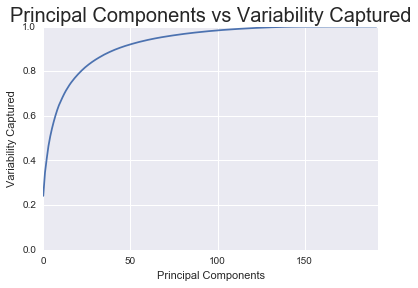

In [13]:
#plotting the variability captured per principal component
plt.plot(range(192), np.cumsum(pca.explained_variance_ratio_))
plt.title('Principal Components vs Variability Captured', fontsize = 20)
plt.xlabel('Principal Components')
plt.ylabel('Variability Captured')
plt.ylim(0,1)
plt.xlim(0,192)

In [14]:
#refitting to the train data but this time specifying 130 components, transforming train and validation
pca = PCA(n_components = 130)
X_train = pca.fit(X_train).transform(X_train)
X_test = pca.transform(X_test)

# Benchmark with Tuned KNN

In [85]:
#using grid search on weights and n_neighbors for KNN classifier
parameters = {'weights':('distance','uniform'),'n_neighbors': [2,3,4,5,6,7,8,9]}
knn = KNeighborsClassifier()
logloss = make_scorer(log_loss,greater_is_better=False, needs_proba=True)
grid_obj = GridSearchCV(estimator=knn, param_grid = parameters, scoring = logloss)

In [86]:
grid_obj.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9], 'weights': ('distance', 'uniform')},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
       verbose=0)

In [87]:
clf = grid_obj.best_estimator_

In [90]:
#best model shows a weights of distance and an n_neighbors of 4
grid_obj.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')

In [94]:
#using the best model to predict the validation set 
preds = clf.predict_proba(X_test)
#getting the logloss of the predictions against the real values
logloss = log_loss(y_test,preds)

In [95]:
print 'The tuned KNN model has a logloss of', logloss,'with n_neighbors equal to 4 and using the weights distance'

The tuned KNN model has a logloss of 0.0580618391794 with n_neighbors equal to 4 and using the weights distance


# Training Neural Networks

In [96]:
#setting the seed so the same randome number sequence is used
np.random.seed(0)

In [100]:
#to_categorical will one-hot encode the 99 classes necessary duing model fitting
y_trainkeras = to_categorical(y_train)

# Trial 1

In [107]:
#2-layer neural network as first run
model = Sequential()
model.add(Dense(1024,input_dim=130,  init='uniform', activation='relu'))
model.add(Dense(99, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics = ["accuracy"])

In [110]:
#fitting the model with train data and one hot encoded y variable
history = model.fit(X_train, y_trainkeras, batch_size = 128, nb_epoch=30,verbose=1)

Epoch 1/30
792/792 [==============================] - 156s - loss: 3.6811 - acc: 0.3725   
Epoch 2/30
792/792 [==============================] - 155s - loss: 1.7789 - acc: 0.9419   
Epoch 3/30
792/792 [==============================] - 155s - loss: 0.9460 - acc: 0.9861   
Epoch 4/30
792/792 [==============================] - 153s - loss: 0.5161 - acc: 0.9937   
Epoch 5/30
792/792 [==============================] - 153s - loss: 0.3000 - acc: 0.9987   
Epoch 6/30
792/792 [==============================] - 156s - loss: 0.1835 - acc: 0.9987   
Epoch 7/30
792/792 [==============================] - 153s - loss: 0.1158 - acc: 1.0000   
Epoch 8/30
792/792 [==============================] - 153s - loss: 0.0762 - acc: 1.0000   
Epoch 9/30
792/792 [==============================] - 157s - loss: 0.0507 - acc: 1.0000   
Epoch 10/30
792/792 [==============================] - 153s - loss: 0.0344 - acc: 1.0000   
Epoch 11/30
792/792 [==============================] - 153s - loss: 0.0231 - acc: 1.0000 

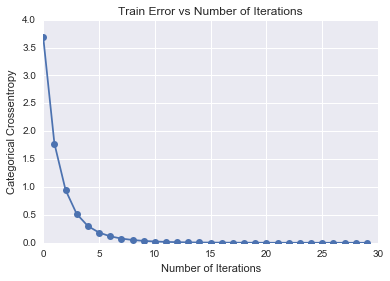

In [111]:
#plotting train error for this model against number of epochs
plt.plot(history.history['loss'],'o-')
plt.xlabel('Number of Iterations')
plt.ylabel('Categorical Crossentropy')
plt.title('Train Error vs Number of Iterations')

In [112]:
#getting the predictions for the model using predict_proba and getting the logloss of these predictions with the real y values
trial1 = model.predict_proba(X_test)
trial1score = log_loss(y_test, trial1)

198/198 [==============================] - 4s     


In [113]:
print 'The validation score for neural networks first trial is', trial1score

The validation score for neural networks first trial is 0.00693362590031


Getting a CSV Output for Trial 1

In [ ]:
#preprocessing the real test set using scaler-standardization and pca that was used to fit the train data
test = test.reset_index()
ID = test.pop('id')
test = scaler.transform(test)
test = pca.transform(test)

In [114]:
#using the model to predict the test data
preds = model.predict_proba(test)
#creating the formatting requirements for submission to kaggle website
preds = pd.DataFrame(preds)
preds = preds.set_index(ID).reset_index()
preds.set_index('id',inplace=True)
preds.columns = lespecies.classes_
preds.reset_index(inplace=True)
#exporting as csv
preds.to_csv('leaves3.csv',index=False)

594/594 [==============================] - 17s    


# Trial 2

In [97]:
#adding one more layer to the model in trial one
model2 = Sequential()
model2.add(Dense(1024,input_dim=130,  init='uniform', activation='relu'))
#adding dropouts to regularize the model
model2.add(Dropout(0.2))
model2.add(Dense(512, activation='sigmoid'))
model2.add(Dropout(0.3))
model2.add(Dense(99, activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics = ["accuracy"])

In [101]:
history2 = model2.fit(X_train,y_trainkeras,batch_size = 128, nb_epoch=30,verbose=1)

Epoch 1/30
792/792 [==============================] - 510s - loss: 4.4962 - acc: 0.0619    
Epoch 2/30
792/792 [==============================] - 546s - loss: 3.4872 - acc: 0.3472    
Epoch 3/30
792/792 [==============================] - 503s - loss: 2.8473 - acc: 0.6035    
Epoch 4/30
792/792 [==============================] - 482s - loss: 2.2360 - acc: 0.7563    
Epoch 5/30
792/792 [==============================] - 470s - loss: 1.7848 - acc: 0.8460    
Epoch 6/30
792/792 [==============================] - 508s - loss: 1.3545 - acc: 0.9104    
Epoch 7/30
792/792 [==============================] - 520s - loss: 1.0611 - acc: 0.9306    
Epoch 8/30
792/792 [==============================] - 521s - loss: 0.7970 - acc: 0.9634    
Epoch 9/30
792/792 [==============================] - 553s - loss: 0.5860 - acc: 0.9823    
Epoch 10/30
792/792 [==============================] - 533s - loss: 0.4478 - acc: 0.9861    
Epoch 11/30
792/792 [==============================] - 466s - loss: 0.3471 - ac

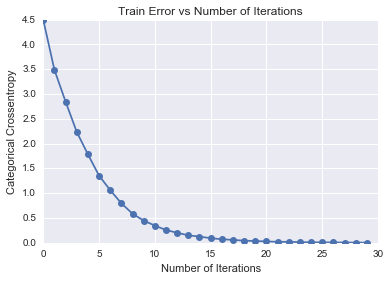

In [102]:
#plotting train error for this model against number of epochs
plt.plot(history2.history['loss'],'o-')
plt.xlabel('Number of Iterations')
plt.ylabel('Categorical Crossentropy')
plt.title('Train Error vs Number of Iterations')

In [103]:
#getting the predictions for the model using predict_proba and getting the logloss of these predictions with the real y values
trial2 = model2.predict_proba(X_test)
trial2score = log_loss(y_test, trial2)

198/198 [==============================] - 22s    


In [150]:
print 'The validation score for neural networks second trial is', trial2score

The validation score for neural networks second trial is 0.0171678940185


Getting a CSV Output for Trial 2

In [106]:
#using the model to predict the test data
preds = model2.predict_proba(test)
#creating the formatting requirements for submission to kaggle website
preds = pd.DataFrame(preds)
preds = preds.set_index(ID).reset_index()
preds.set_index('id',inplace=True)
preds.columns = lespecies.classes_
preds.reset_index(inplace=True)
#exporting as csv
preds.to_csv('leaves2.csv',index=False)

594/594 [==============================] - 76s    


# Trial 3

In [127]:
#using the same model as trial one but with optimizer adam
model4 = Sequential()
model4.add(Dense(1024,input_dim=130,  init='uniform', activation='relu'))
model4.add(Dense(99, activation='softmax'))
model4.compile(loss='categorical_crossentropy',optimizer='adam', metrics = ["accuracy"])

In [128]:
history4 = model4.fit(X_train,y_trainkeras,batch_size = 128, nb_epoch=30,verbose=1)

Epoch 1/30
792/792 [==============================] - 187s - loss: 4.1490 - acc: 0.1881   
Epoch 2/30
792/792 [==============================] - 186s - loss: 2.6517 - acc: 0.8674   
Epoch 3/30
792/792 [==============================] - 185s - loss: 1.5853 - acc: 0.9924   
Epoch 4/30
792/792 [==============================] - 194s - loss: 0.8771 - acc: 0.9962   
Epoch 5/30
792/792 [==============================] - 187s - loss: 0.4646 - acc: 0.9962   
Epoch 6/30
792/792 [==============================] - 186s - loss: 0.2539 - acc: 0.9975   
Epoch 7/30
792/792 [==============================] - 185s - loss: 0.1548 - acc: 0.9987   
Epoch 8/30
792/792 [==============================] - 184s - loss: 0.1032 - acc: 1.0000   
Epoch 9/30
792/792 [==============================] - 190s - loss: 0.0751 - acc: 1.0000   
Epoch 10/30
792/792 [==============================] - 192s - loss: 0.0589 - acc: 1.0000   
Epoch 11/30
792/792 [==============================] - 199s - loss: 0.0482 - acc: 1.0000 

In [129]:
#getting the predictions for the model using predict_proba and getting the logloss of these predictions with the real y values
trial4 = model4.predict_proba(X_test)
trial4score = log_loss(y_test, trial4)

198/198 [==============================] - 4s     


In [173]:
print 'The validation score for neural networks third trial is', trial4score

The validation score for neural networks third trial is 0.0554586012


Getting a CSV Output for Trial 3

In [138]:
#using the model to predict the test data
preds = model4.predict_proba(test)
#creating the formatting requirements for submission to kaggle website
preds = pd.DataFrame(preds)
preds = preds.set_index(ID).reset_index()
preds.set_index('id',inplace=True)
preds.columns = lespecies.classes_
preds.reset_index(inplace=True)
#exporting as csv
preds.to_csv('leaves-adam.csv',index=False)

594/594 [==============================] - 15s    


# Trial 4

In [142]:
#using the same model as trial one but with activation sigmoid
model5 = Sequential()
model5.add(Dense(1024,input_dim=130,  init='uniform', activation='sigmoid'))
model5.add(Dense(99, activation='softmax'))
model5.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics = ["accuracy"])

In [143]:
history5 = model5.fit(X_train,y_trainkeras,batch_size = 128, nb_epoch=30,verbose=1)

Epoch 1/30
792/792 [==============================] - 164s - loss: 4.7488 - acc: 0.0366   
Epoch 2/30
792/792 [==============================] - 147s - loss: 4.0151 - acc: 0.2487   
Epoch 3/30
792/792 [==============================] - 126s - loss: 3.5999 - acc: 0.4444   
Epoch 4/30
792/792 [==============================] - 127s - loss: 3.1743 - acc: 0.5505   
Epoch 5/30
792/792 [==============================] - 139s - loss: 2.8673 - acc: 0.6730   
Epoch 6/30
792/792 [==============================] - 148s - loss: 2.5161 - acc: 0.7664   
Epoch 7/30
792/792 [==============================] - 153s - loss: 2.2310 - acc: 0.8384   
Epoch 8/30
792/792 [==============================] - 148s - loss: 1.9326 - acc: 0.8801   
Epoch 9/30
792/792 [==============================] - 156s - loss: 1.6697 - acc: 0.9116   
Epoch 10/30
792/792 [==============================] - 151s - loss: 1.4194 - acc: 0.9495   
Epoch 11/30
792/792 [==============================] - 147s - loss: 1.2064 - acc: 0.9672 

In [144]:
#getting the predictions for the model using predict_proba and getting the logloss of these predictions with the real y values
trial5 = model5.predict_proba(X_test)
trial5score = log_loss(y_test, trial5)

198/198 [==============================] - 2s     


In [174]:
print 'The validation score for neural networks fourth trial is', trial5score

The validation score for neural networks fourth trial is 0.11054457164


Getting CSV Output for Trial 4

In [170]:
#using the model to predict the test data
preds = model5.predict_proba(test)
#creating the formatting requirements for submission to kaggle website
preds = pd.DataFrame(preds)
preds = preds.set_index(ID).reset_index()
preds.set_index('id',inplace=True)
preds.columns = lespecies.classes_
preds.reset_index(inplace=True)
#exporting as csv
preds.to_csv('leaves-sigmoid.csv',index=False)

594/594 [==============================] - 20s    


# Trial 5

In [146]:
#using the same model as trial one but with initialization as normal
model6 = Sequential()
model6.add(Dense(1024,input_dim=130,  init='normal', activation='relu'))
model6.add(Dense(99, activation='softmax'))
model6.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics = ["accuracy"])

In [147]:
history6 = model6.fit(X_train,y_trainkeras,batch_size = 128, nb_epoch=30,verbose=1)

Epoch 1/30
792/792 [==============================] - 123s - loss: 3.5638 - acc: 0.3712   
Epoch 2/30
792/792 [==============================] - 137s - loss: 1.4007 - acc: 0.9280   
Epoch 3/30
792/792 [==============================] - 136s - loss: 0.6846 - acc: 0.9861   
Epoch 4/30
792/792 [==============================] - 135s - loss: 0.3640 - acc: 0.9949   
Epoch 5/30
792/792 [==============================] - 134s - loss: 0.2191 - acc: 0.9987   
Epoch 6/30
792/792 [==============================] - 135s - loss: 0.1370 - acc: 1.0000   
Epoch 7/30
792/792 [==============================] - 133s - loss: 0.0891 - acc: 1.0000   
Epoch 8/30
792/792 [==============================] - 132s - loss: 0.0595 - acc: 0.9987   
Epoch 9/30
792/792 [==============================] - 136s - loss: 0.0399 - acc: 1.0000   
Epoch 10/30
792/792 [==============================] - 131s - loss: 0.0273 - acc: 1.0000   
Epoch 11/30
792/792 [==============================] - 123s - loss: 0.0191 - acc: 1.0000 

In [148]:
#getting the predictions for the model using predict_proba and getting the logloss of these predictions with the real y values
trial6 = model6.predict_proba(X_test)
trial6score = log_loss(y_test, trial6)

198/198 [==============================] - 4s     


In [149]:
print 'The validation score for neural networks sixth trial is', trial6score

The validation score for neural networks sixth trial is 0.0124815864758


Getting CSV Output for Trial 5

In [171]:
#using the model to predict the test data
preds = model6.predict_proba(test)
#creating the formatting requirements for submission to kaggle website
preds = pd.DataFrame(preds)
preds = preds.set_index(ID).reset_index()
preds.set_index('id',inplace=True)
preds.columns = lespecies.classes_
preds.reset_index(inplace=True)
#exporting as csv
preds.to_csv('leaves-normal.csv',index=False)

594/594 [==============================] - 23s    
